In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load constants
FREQ_START = 1419.84
FREQ_STEP = 0.00781250
RECORDINGMODE = 4
NBINS = 148
tsys = 0

In [127]:
# set data indices
CMD = 0
DATA_START = 12

# load raw data from rad file. 
# returns calibration tsys and a matrix where each row has form:
# CMD, TIMESTAMP, AZ, EL, AZOFF, ELOFF, GLON, GLAT, FREQ_START, FREQ_STEP, RECORDINGMODE, # OF BINS, *DATA (in K)
def load_data(file):
    with open(file) as f:
        data = []
        lines = f.readlines()
        for i in range(len(lines)):
            if 'cmd' in lines[i]: # comments with 'cmd' indicate execution of a line from the .cmd file
                data.append([lines[i]] + lines[i+1].split()[:-2]) # ignore vlsr data
            elif 'tsys' in lines[i]:
                tsys = int(lines[i].split()[2]) # hardcode location of tsys value
        return tsys, np.array(data)

# Sun Sweep Analysis

### TODO:
* add a parameter for horizontal shift
* decide what to do with the vertical shift (theoretically we should subtract tsys from everything, but this makes some values negative
* all sweeps except 171110-01 are broken
* find the aperture of the SRT

In [144]:
# remove background t from data
def remove_background(sweep, tsys):
    remove_background = sweep - np.min(sweep)
    drop_negatives = np.where(remove_background > 0, remove_background, 0)
    return remove_background

# convert antenna temperature to brightness temperature
def antennaT_to_brightnessT(sweep):
    ANTENNA_ANG_DIAM = 7
    SOURCE_ANG_DIAM = .5
    POLARIZATION_FACTOR = 2 # antenna only measures 1 polarization direction
    return sweep * (ANTENNA_ANG_DIAM / SOURCE_ANG_DIAM)**2 * POLARIZATION_FACTOR

# process sunsweep data
# input: full rows from load_data
# output: avg brightness temperature for each angle with error
def process_sunsweep(raw_data):
    # TODO: DATA_START should be calcuated from raw_data rather than stored globally
    rm_metadata = np.asfarray(raw_data[:, DATA_START:], float)
    avg_antennaT = np.mean(rm_metadata, axis=1)
    rm_bg_antennaT = remove_background(avg_antennaT, tsys)
    avg_brightnessT = antennaT_to_brightnessT(rm_bg_antennaT)

    err_antennaT = np.sqrt(avg_antennaT)
    err_brightnessT = antennaT_to_brightnessT(err_antennaT)
    
    utils.init_plot()
    utils.plot_data(range(len(avg_brightnessT)), avg_brightnessT, err_brightnessT)
    plt.show()
    
    return avg_brightnessT, err_brightnessT

In [147]:
# define diffraction model
# TODO: note that the aperture is left floating. we should try to find the actual value for this.
import scipy.special
def circular_diffraction(theta, I, a):
    k = 29.7695032399
    return np.where(theta == 0, I, I * ( (2 * scipy.special.j1(k * a * np.sin(theta))) / (k * a * np.sin(theta)) )**2)

In [175]:
# load data to tsys, raw
file = '21cm/sunsweeps/171110-01.rad'
tsys, raw = load_data(file)

In [176]:
# select rows to analyze
# TODO: make more robust selection mechanism (perhaps by adding comments to the cmd file?)
azsweep = np.array([raw[i] for i in range(5, 36)])
elsweep = np.array([raw[i] for i in range(36, 67)])

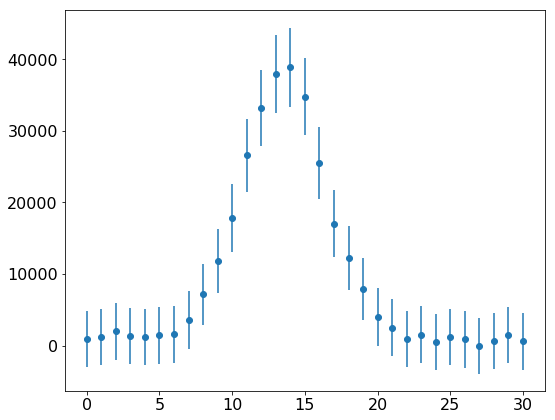

[  3.18047046e+04   7.65961592e-01] [  2.44678506e+03   5.57088935e-02] 39.3327695473


/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [177]:
x = np.array([i*2*3.14/360 for i in range(-15, 16, 1)])
y, ey = process_sunsweep(elsweep)

popt, perr, chisq = utils.fit_model(x, y, ey, (30000, 1), circular_diffraction)
print(popt, perr, chisq)

/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


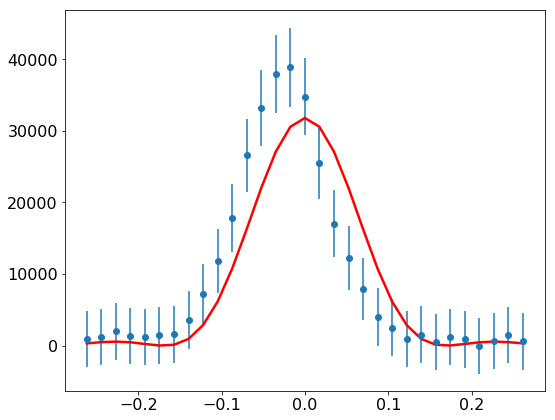

In [178]:
utils.init_plot()
utils.plot_data(x, y, ey)
utils.plot_model(x, circular_diffraction, popt, 'r', '')
plt.show()